
<img src='https://www.e-mj.com/wp-content/uploads/2019/12/2-1.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href=https://www.e-mj.com/features/froth-flotation-for-the-21st-century/'>E&MJ Engineering and Mining Journal</a> 
    </strong>
</figcaption>

# 1. Introduction to the Dataset And The Aim of the EDA




Iron ore flotation is a key process in iron metal extraction, but growing ore complexity, depleting high-grade mineral reserves and stricter quality demands make optimization increasingly difficult. Today’s industry faces major challenges: Retracting ore grades, maximizing recovery, improving concentrate grade, and reducing environmental impact.

To stay competitive, it's essential to analyze process data and understand how key variables affect flotation performance.

This [dataset](https://www.kaggle.com/datasets/veeralakrishna/froth-flotation), with more than half a million rows, is used to gain insights into flotation performance and will support the automation of reagent dosing—specifically amine and starch. The goal is to address the common issue where manual adjustments lead to inefficiencies, inconsistent recovery, and suboptimal concentrate grade.


## 1.1 Library Setup and Read in the Data

You will need to install additional libraries: `empiricaldist` and `missingno`:

In [2]:
#!pip -q install empiricaldist

In [3]:
#!pip -q install missingno

In [35]:
# Base libraries
import time
import datetime
import os

# Scientific libraries
import numpy as np
import pandas as pd
from empiricaldist import Cdf, Pmf

# Visual libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import missingno as msno  # Visualize missing values

# Helper libraries
from tqdm.notebook import tqdm, trange
from colorama import Fore, Back, Style
import warnings
warnings.filterwarnings('ignore')

# Visual setup
import matplotlib.ticker as ticker
plt.style.use('ggplot')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.set_palette(custom_colors)
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

# Pandas options
pd.set_option('display.max_columns',None)
pd.options.display.max_columns = None  # Possible to limit
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Seed value for numpy.random
np.random.seed(42)

Load in the data:

In [36]:
feed = pd.read_csv('feed.csv')
flot = pd.read_csv('flotation.csv')

# 2. Basic Exploration and Data Cleaning

## 2.1 Basic Exploration

We will start with basic exploration of the dataset and get a feel for how it looks.

In [37]:
(feed.info())
(flot.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589962 entries, 0 to 589961
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            589962 non-null  int64  
 1   X1                    589962 non-null  float64
 2   date                  589962 non-null  object 
 3   % Iron Feed           589962 non-null  float64
 4   % Silica Feed         589962 non-null  float64
 5   Starch Flow           589962 non-null  float64
 6   Amina Flow            589962 non-null  float64
 7   Ore Pulp Flow         589962 non-null  float64
 8   Ore Pulp pH           589962 non-null  float64
 9   Ore Pulp Density      589962 non-null  float64
 10  % Iron Concentrate    589962 non-null  float64
 11  % Silica Concentrate  589962 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 54.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589962 entries, 0 to 589961
Data columns (total

There are 23 columns and several of them have missing values. I like creating a single cell to list all the issues that need addressing and deal with them separately after I am done exploring. Then, I can cross each issue one by one as I fix them.

In [38]:
feed.isnull().sum()
flot.isnull().sum()

Unnamed: 0              0
X1                      0
date                    0
% Iron Feed             0
% Silica Feed           0
Starch Flow             0
Amina Flow              0
Ore Pulp Flow           0
Ore Pulp pH             0
Ore Pulp Density        0
% Iron Concentrate      0
% Silica Concentrate    0
dtype: int64

Unnamed: 0                      0
X1                              0
date                            0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
dtype: int64

I like the columns of my dataset to have *snake_case* because it will be easier to choose them later on (added to the list).

Also, I think these columns will not be useful for us: App ID, minimum and maximum installs, minimum android version, developer ID, website and email, privacy policy link.

Next, looking at the dataset info again:

Some columns have incorrect data types: Released, Size. Released should be a `datetime`. Size is probably rendered as string because each size contains the letter 'M' to indicate megabytes. These issues will be added to the list too.


Now, let's look at the app categories:

If we look carefully, some categories of interest like Music and Eduction are given with different labels: there are both 'Music & Audio' and 'Music' labels as well as 'Education' and 'Educational' for education. They should be merged together to represent a single category. 

Later, we will subset for the top 8 columns after finishing cleaning.

Now, let's explore the numerical features of the dataset and see if they contain any issues:

In [39]:
feed.describe()
flot.describe()

Unnamed: 0             X1    % Iron Feed  % Silica Feed  \
count  589962.000000  589962.000000  589962.000000  589962.000000   
mean   294981.500000  294980.500000      56.999584      13.805638   
std    170307.504093  170307.504093       5.075945       6.521040   
min         1.000000       0.000000      43.370000       3.850000   
25%    147491.250000  147490.250000      53.320000       6.650000   
50%    294981.500000  294980.500000      56.700000      13.070000   
75%    442471.750000  442470.750000      61.320000      18.380000   
max    589962.000000  589961.000000      64.480000      32.230000   

         Starch Flow     Amina Flow  Ore Pulp Flow    Ore Pulp pH  \
count  589962.000000  589962.000000  589962.000000  589962.000000   
mean     2821.459237     489.946910     399.776809       9.819818   
std      1237.413695      90.003667       6.693449       0.350645   
min         0.002026     241.694000     376.250000       8.753340   
25%      2013.732500     438.776250     396.878000       9.587720   
50%      2990.110000     506.999000     399.991000       9.834420   
75%      3725.720000     553.569000     403.112326      10.062900   
max      6300.230000     739.538000     418.640000      10.808100   

       Ore Pulp Density  % Iron Concentrate  % Silica Concentrate  
count     589962.000000       589962.000000         589962.000000  
mean           1.679207           65.124118              2.335008  
std            0.072486            1.491434              1.120421  
min            1.519820           58.215429              0.770000  
25%            1.641590           64.155861              1.450000  
50%            1.697520           65.198300              2.010000  
75%            1.732180           66.163060              3.038286  
max            1.853100           71.337488              5.530000

Unnamed: 0             X1  Flotation Column 01 Air Flow  \
count  589962.000000  589962.000000                 589962.000000   
mean   294981.500000  294980.500000                    275.765529   
std    170307.504093  170307.504093                     30.657786   
min         1.000000       0.000000                    175.510000   
25%    147491.250000  147490.250000                    250.077000   
50%    294981.500000  294980.500000                    298.821000   
75%    442471.750000  442470.750000                    300.052000   
max    589962.000000  589961.000000                    373.871000   

       Flotation Column 02 Air Flow  Flotation Column 03 Air Flow  \
count                 589962.000000                 589962.000000   
mean                     272.458304                    276.952692   
std                       30.602411                     29.886895   
min                      175.156000                    176.469000   
25%                      249.587000                    250.094000   
50%                      290.269500                    298.365000   
75%                      299.997000                    300.122000   
max                      375.965000                    363.122000   

       Flotation Column 04 Air Flow  Flotation Column 05 Air Flow  \
count                 589962.000000                 589962.000000   
mean                     299.220618                    300.147455   
std                        2.475159                      3.689377   
min                      292.195000                    286.295000   
25%                      297.989000                    298.177000   
50%                      299.733000                    299.949000   
75%                      300.516000                    302.039000   
max                      305.871000                    310.270000   

       Flotation Column 06 Air Flow  Flotation Column 07 Air Flow  \
count                 589962.000000                 589962.000000   
mean                     287.494720                    287.795267   
std                       27.088711                     26.638950   
min                      192.211000                    185.962000   
25%                      251.682250                    252.342000   
50%                      298.910000                    298.828000   
75%                      300.923000                    301.090000   
max                      370.899000                    371.590000   

       Flotation Column 01 Level  Flotation Column 02 Level  \
count              589962.000000              589962.000000   
mean                  525.801082                 527.619136   
std                   135.797528                 136.577030   
min                   149.293000                 210.752000   
25%                   424.171250                 436.600000   
50%                   488.829000                 489.490000   
75%                   599.171750                 601.523000   
max                   862.274000                 828.919000   

       Flotation Column 03 Level  Flotation Column 04 Level  \
count              589962.000000              589962.000000   
mean                  534.096148                 422.877318   
std                   153.874154                  88.738162   
min                   126.255000                 162.251000   
25%                   413.158250                 359.475250   
50%                   492.302000                 416.989000   
75%                   602.148000                 486.835000   
max                   886.822000                 680.359000   

       Flotation Column 05 Level  Flotation Column 06 Level  \
count              589962.000000              589962.000000   
mean                  428.288038                 429.654914   
std                    82.303665                  86.728242   
min                   166.999000                 155.841000   
25%                   361.651000                 359.720000   
50%     

Looks like all numerical columns are within the sensible range, like rating should be between 0 and 5. But the maximum value for price is 400$ which is a bit suspicious. We will dig into that later.

Before we further explore, let's deal with the issues we highlighted. Here is the final list:

### Issues List For the Dataset
- Missing values in several cols: Rating, rating count, Installs, minimum and maximum installs, currency and more
- Convert all columns to snake_case
- Drop these columns: App ID, minimum and maximum installs, minimum android version, developer ID, website and email, privacy policy link.
- Incorrect data types for release data and size
- Music and education is represented by different labels
- Drop unnecessary categories

## 2.2 Data Cleaning

It is a good practice to start cleaning from the easiest issues.

### Merging both the datasets to get a master dataset

Check the results:

In [40]:
feed.columns
flot.columns

Index(['Unnamed: 0', 'X1', 'date', '% Iron Feed', '% Silica Feed',
       'Starch Flow', 'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp pH',
       'Ore Pulp Density', '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

Index(['Unnamed: 0', 'X1', 'date', 'Flotation Column 01 Air Flow',
       'Flotation Column 02 Air Flow', 'Flotation Column 03 Air Flow',
       'Flotation Column 04 Air Flow', 'Flotation Column 05 Air Flow',
       'Flotation Column 06 Air Flow', 'Flotation Column 07 Air Flow',
       'Flotation Column 01 Level', 'Flotation Column 02 Level',
       'Flotation Column 03 Level', 'Flotation Column 04 Level',
       'Flotation Column 05 Level', 'Flotation Column 06 Level',
       'Flotation Column 07 Level'],
      dtype='object')

### Drop unnecessary columns

In [41]:
# Specify the cols to drop
to_drop = ['Unnamed: 0', 'X1']

# Drop them
feed.drop(to_drop, axis='columns', inplace=True)
flot.drop(to_drop, axis='columns', inplace=True)


Check:

In [42]:
assert feed.columns.all() not in to_drop
assert flot.columns.all() not in to_drop

In [43]:
data = (pd.merge(feed,flot, on = 'date', how='outer'))

Check: 

In [44]:
data.columns.unique().value_counts()

date                            1
% Iron Feed                     1
Flotation Column 06 Level       1
Flotation Column 05 Level       1
Flotation Column 04 Level       1
Flotation Column 03 Level       1
Flotation Column 02 Level       1
Flotation Column 01 Level       1
Flotation Column 07 Air Flow    1
Flotation Column 06 Air Flow    1
Flotation Column 05 Air Flow    1
Flotation Column 04 Air Flow    1
Flotation Column 03 Air Flow    1
Flotation Column 02 Air Flow    1
Flotation Column 01 Air Flow    1
% Silica Concentrate            1
% Iron Concentrate              1
Ore Pulp Density                1
Ore Pulp pH                     1
Ore Pulp Flow                   1
Amina Flow                      1
Starch Flow                     1
% Silica Feed                   1
Flotation Column 07 Level       1
Name: count, dtype: int64

#No duplicate columns

In [45]:
data

date  % Iron Feed  % Silica Feed  Starch Flow  \
0       2017-03-10 01:02:00        55.20          16.98      3019.53   
1       2017-03-10 01:02:20        55.20          16.98      3024.41   
2       2017-03-10 01:02:40        55.20          16.98      3043.46   
3       2017-03-10 01:03:00        55.20          16.98      3047.36   
4       2017-03-10 01:03:20        55.20          16.98      3033.69   
...                     ...          ...            ...          ...   
589957  2017-08-06 20:34:40        54.43          17.29      2150.39   
589958  2017-08-06 20:35:00        54.43          17.29      2171.75   
589959  2017-08-06 20:35:20        54.43          17.29      2193.36   
589960  2017-08-06 20:35:40        54.43          17.29      2248.50   
589961  2017-08-06 20:59:40        54.43          17.29      2026.82   

        Amina Flow  Ore Pulp Flow  Ore Pulp pH  Ore Pulp Density  \
0          557.434      395.71300     10.06640           1.74000   
1          563.965      397.38300     10.06720           1.74000   
2          568.054      399.66800     10.06800           1.74000   
3          568.665      397.93900     10.06890           1.74000   
4          558.167      400.25400     10.06970           1.74000   
...            ...            ...          ...               ...   
589957     434.560      378.40372      9.89425           1.66286   
589958     418.998      378.39560      9.89520           1.66261   
589959     424.805      378.38748      9.89614           1.66237   
589960     409.017      378.37936      9.89708           1.66212   
589961     546.051      376.79600      9.81691           1.71365   

        % Iron Concentrate  % Silica Concentrate  \
0                66.493242                  1.31   
1                66.853733                  1.31   
2                64.773804                  1.31   
3                68.550271                  1.31   
4                65.116564                  1.31   
...                    ...                   ...   
589957           64.585422                  2.24   
589958           64.173481                  2.24   
589959           64.644882                  2.24   
589960           65.641438                  2.24   
589961           63.722241                  2.24   

        Flotation Column 01 Air Flow  Flotation Column 02 Air Flow  \
0                            249.214                       253.235   
1                            249.719                       250.532   
2                            249.741                       247.874   
3                            249.917                       254.487   
4                            250.203                       252.136   
...                              ...                           ...   
589957                       298.705                       294.337   
589958                       298.828                       298.955   
589959                       298.828                       304.980   
589960                       299.599                       305.944   
589961                       300.146                       303.093   

        Flotation Column 03 Air Flow  Flotation Column 04 Air Flow  \
0                            250.576                    295.096000   
1                            250.862                    295.096000   
2                            250.313                    295.096000   
3                            250.049                    295.096000   
4                            249.895                    295.096000   
...                              ...                           ...   
589957                       300.858                    304.910167   
589958                       300.560                    304.910129   
589959                       300.806                    304.910091   
589960                       300.902                    304.910053   
589961                       298.118                    304.914132   

        Flotation Column 05 Air Fl

There seems to be much more missing values in `size`, well over the threshold where we can safely drop them. Let's dive deeper using the `missingno` package:

### Deal With Missing Values

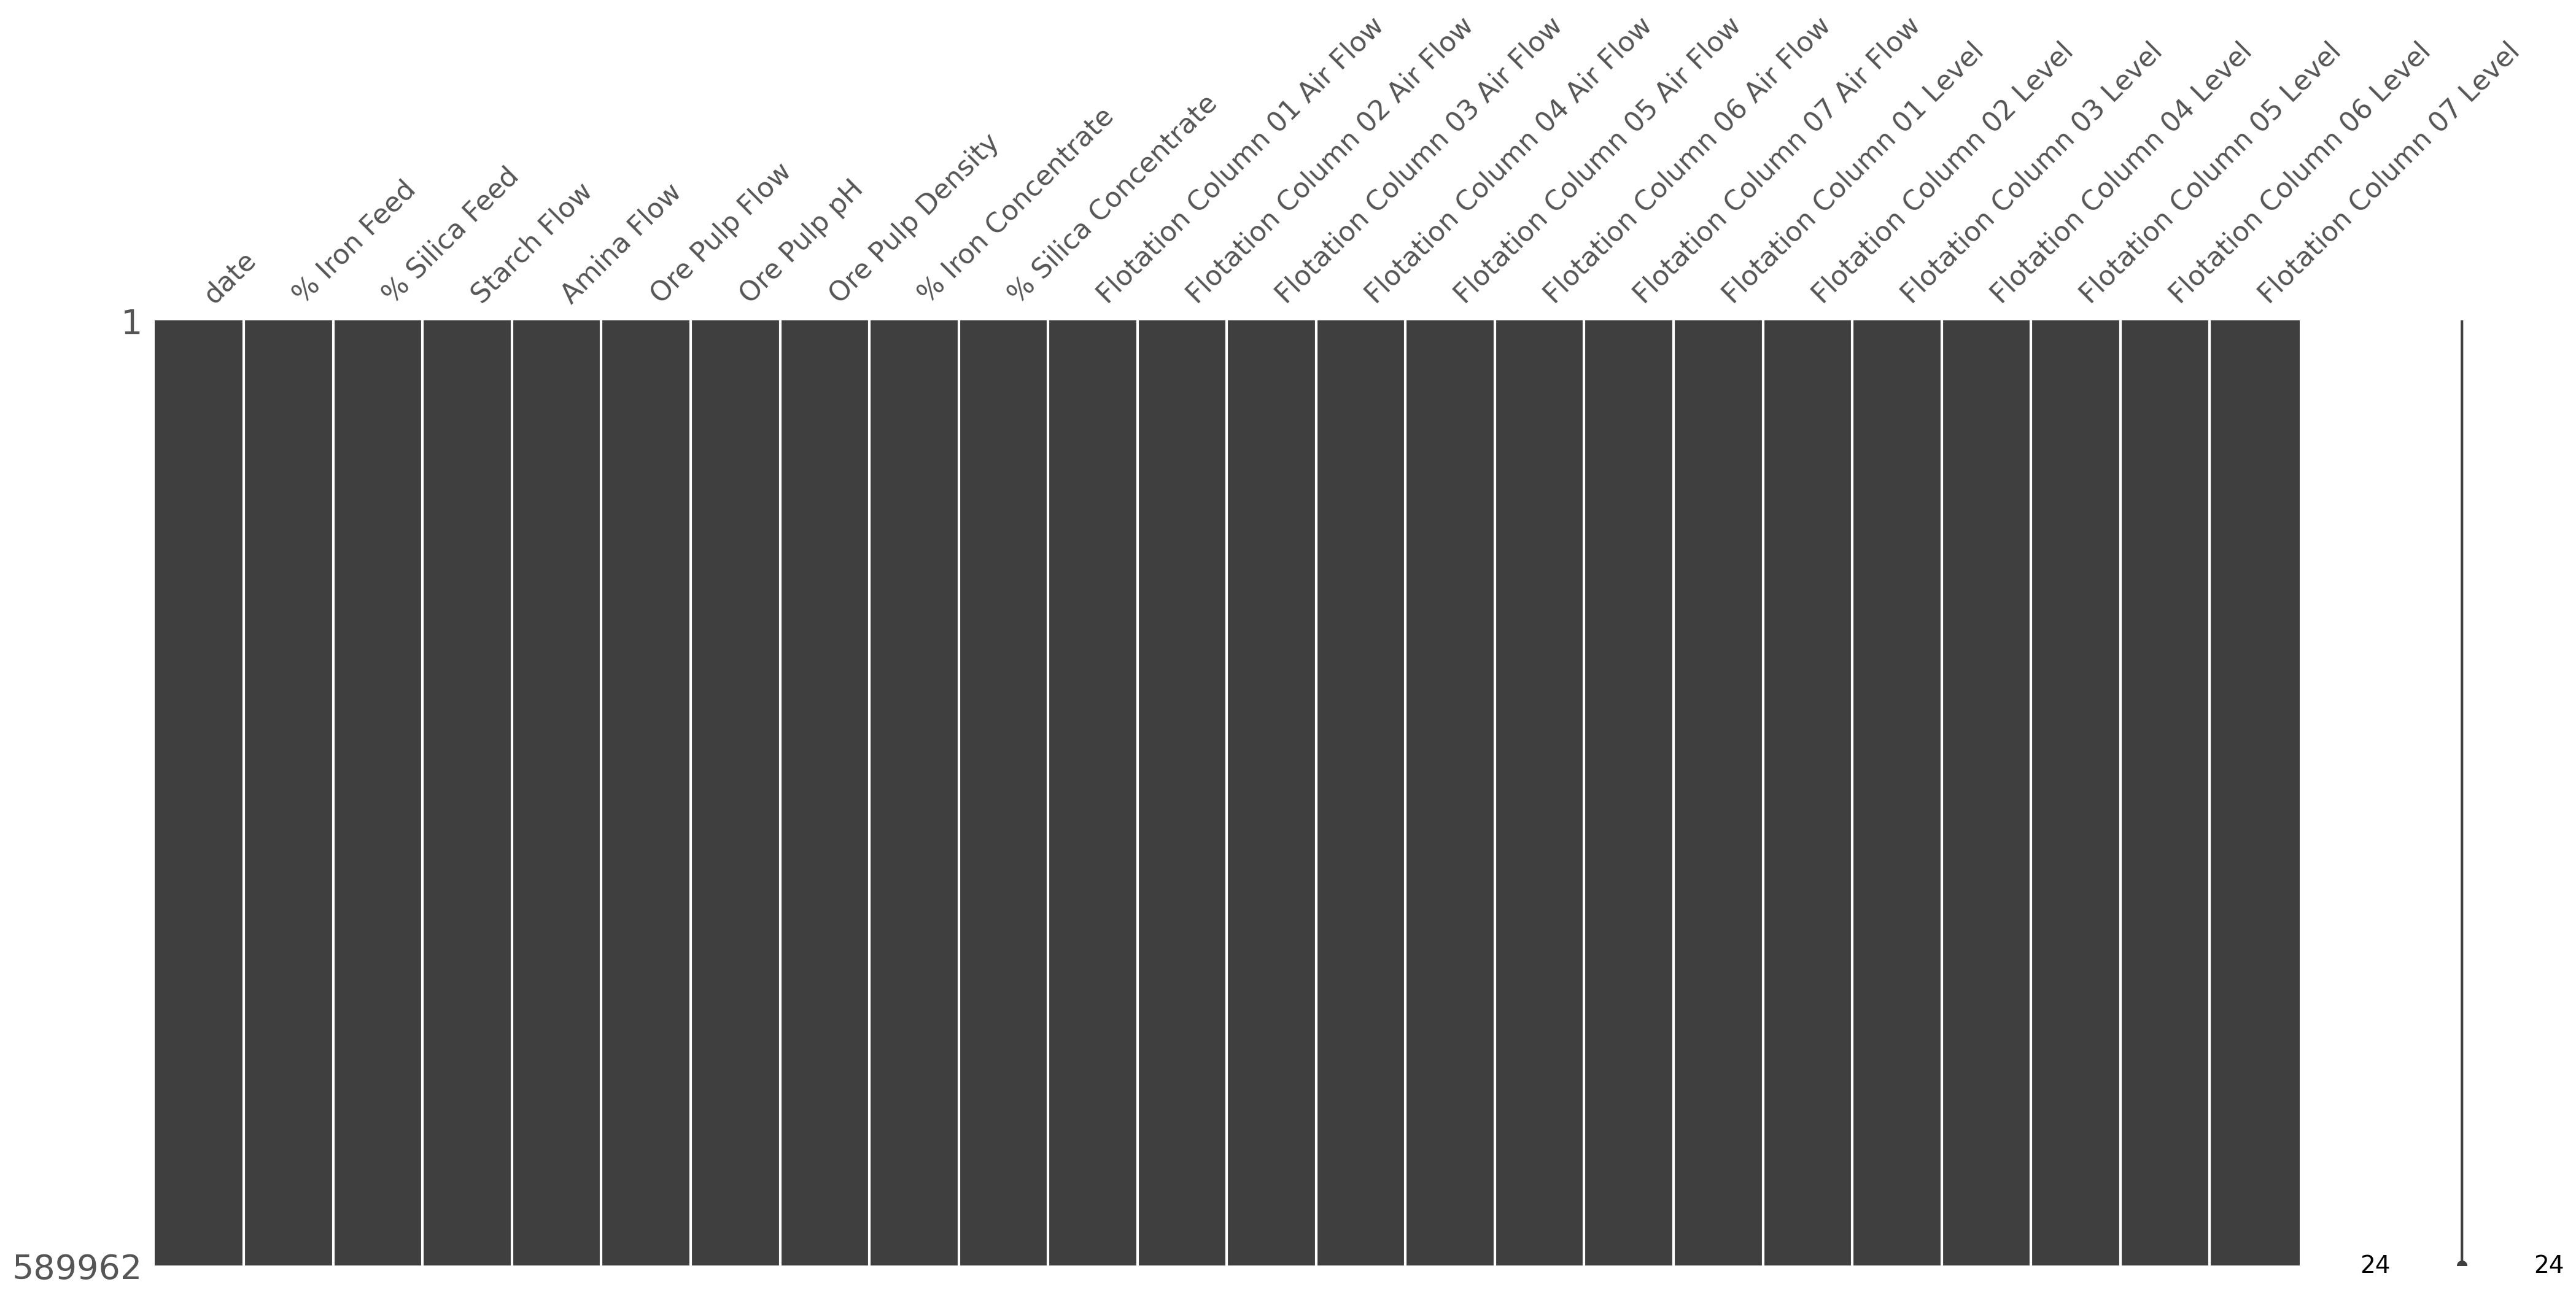

In [46]:
msno.matrix(data);

#No data missing. In case of missing data, there would be white lines on that particular place in dataframe.

### Convert `date` to `datetime' 

In [47]:
# Convert 'date' to datetime and set as index
data['date'] = pd.to_datetime(data['date'])


Check:

In [48]:
data.columns.unique().value_counts()

date                            1
% Iron Feed                     1
Flotation Column 06 Level       1
Flotation Column 05 Level       1
Flotation Column 04 Level       1
Flotation Column 03 Level       1
Flotation Column 02 Level       1
Flotation Column 01 Level       1
Flotation Column 07 Air Flow    1
Flotation Column 06 Air Flow    1
Flotation Column 05 Air Flow    1
Flotation Column 04 Air Flow    1
Flotation Column 03 Air Flow    1
Flotation Column 02 Air Flow    1
Flotation Column 01 Air Flow    1
% Silica Concentrate            1
% Iron Concentrate              1
Ore Pulp Density                1
Ore Pulp pH                     1
Ore Pulp Flow                   1
Amina Flow                      1
Starch Flow                     1
% Silica Feed                   1
Flotation Column 07 Level       1
Name: count, dtype: int64

Reseting "date" index to avoid any error during model training

### Correlation of in the dataset

The correlation matrix of missingness shows that most nulls in `size` are associated with nulls in `rating` and `rating_count`. This scenario falls into the Missing At Random class of missingness. This means that even though null values are random their misssingness is related to other observed values. 

In most cases, you can impute them with ML techniques. But our case is specific because we don't have enough features that help predict the size or rating of an app. We have no choice but to drop them. (I am not even mentioning nulls in other columns because their proportion is marginal)

<Figure size 3000x1800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

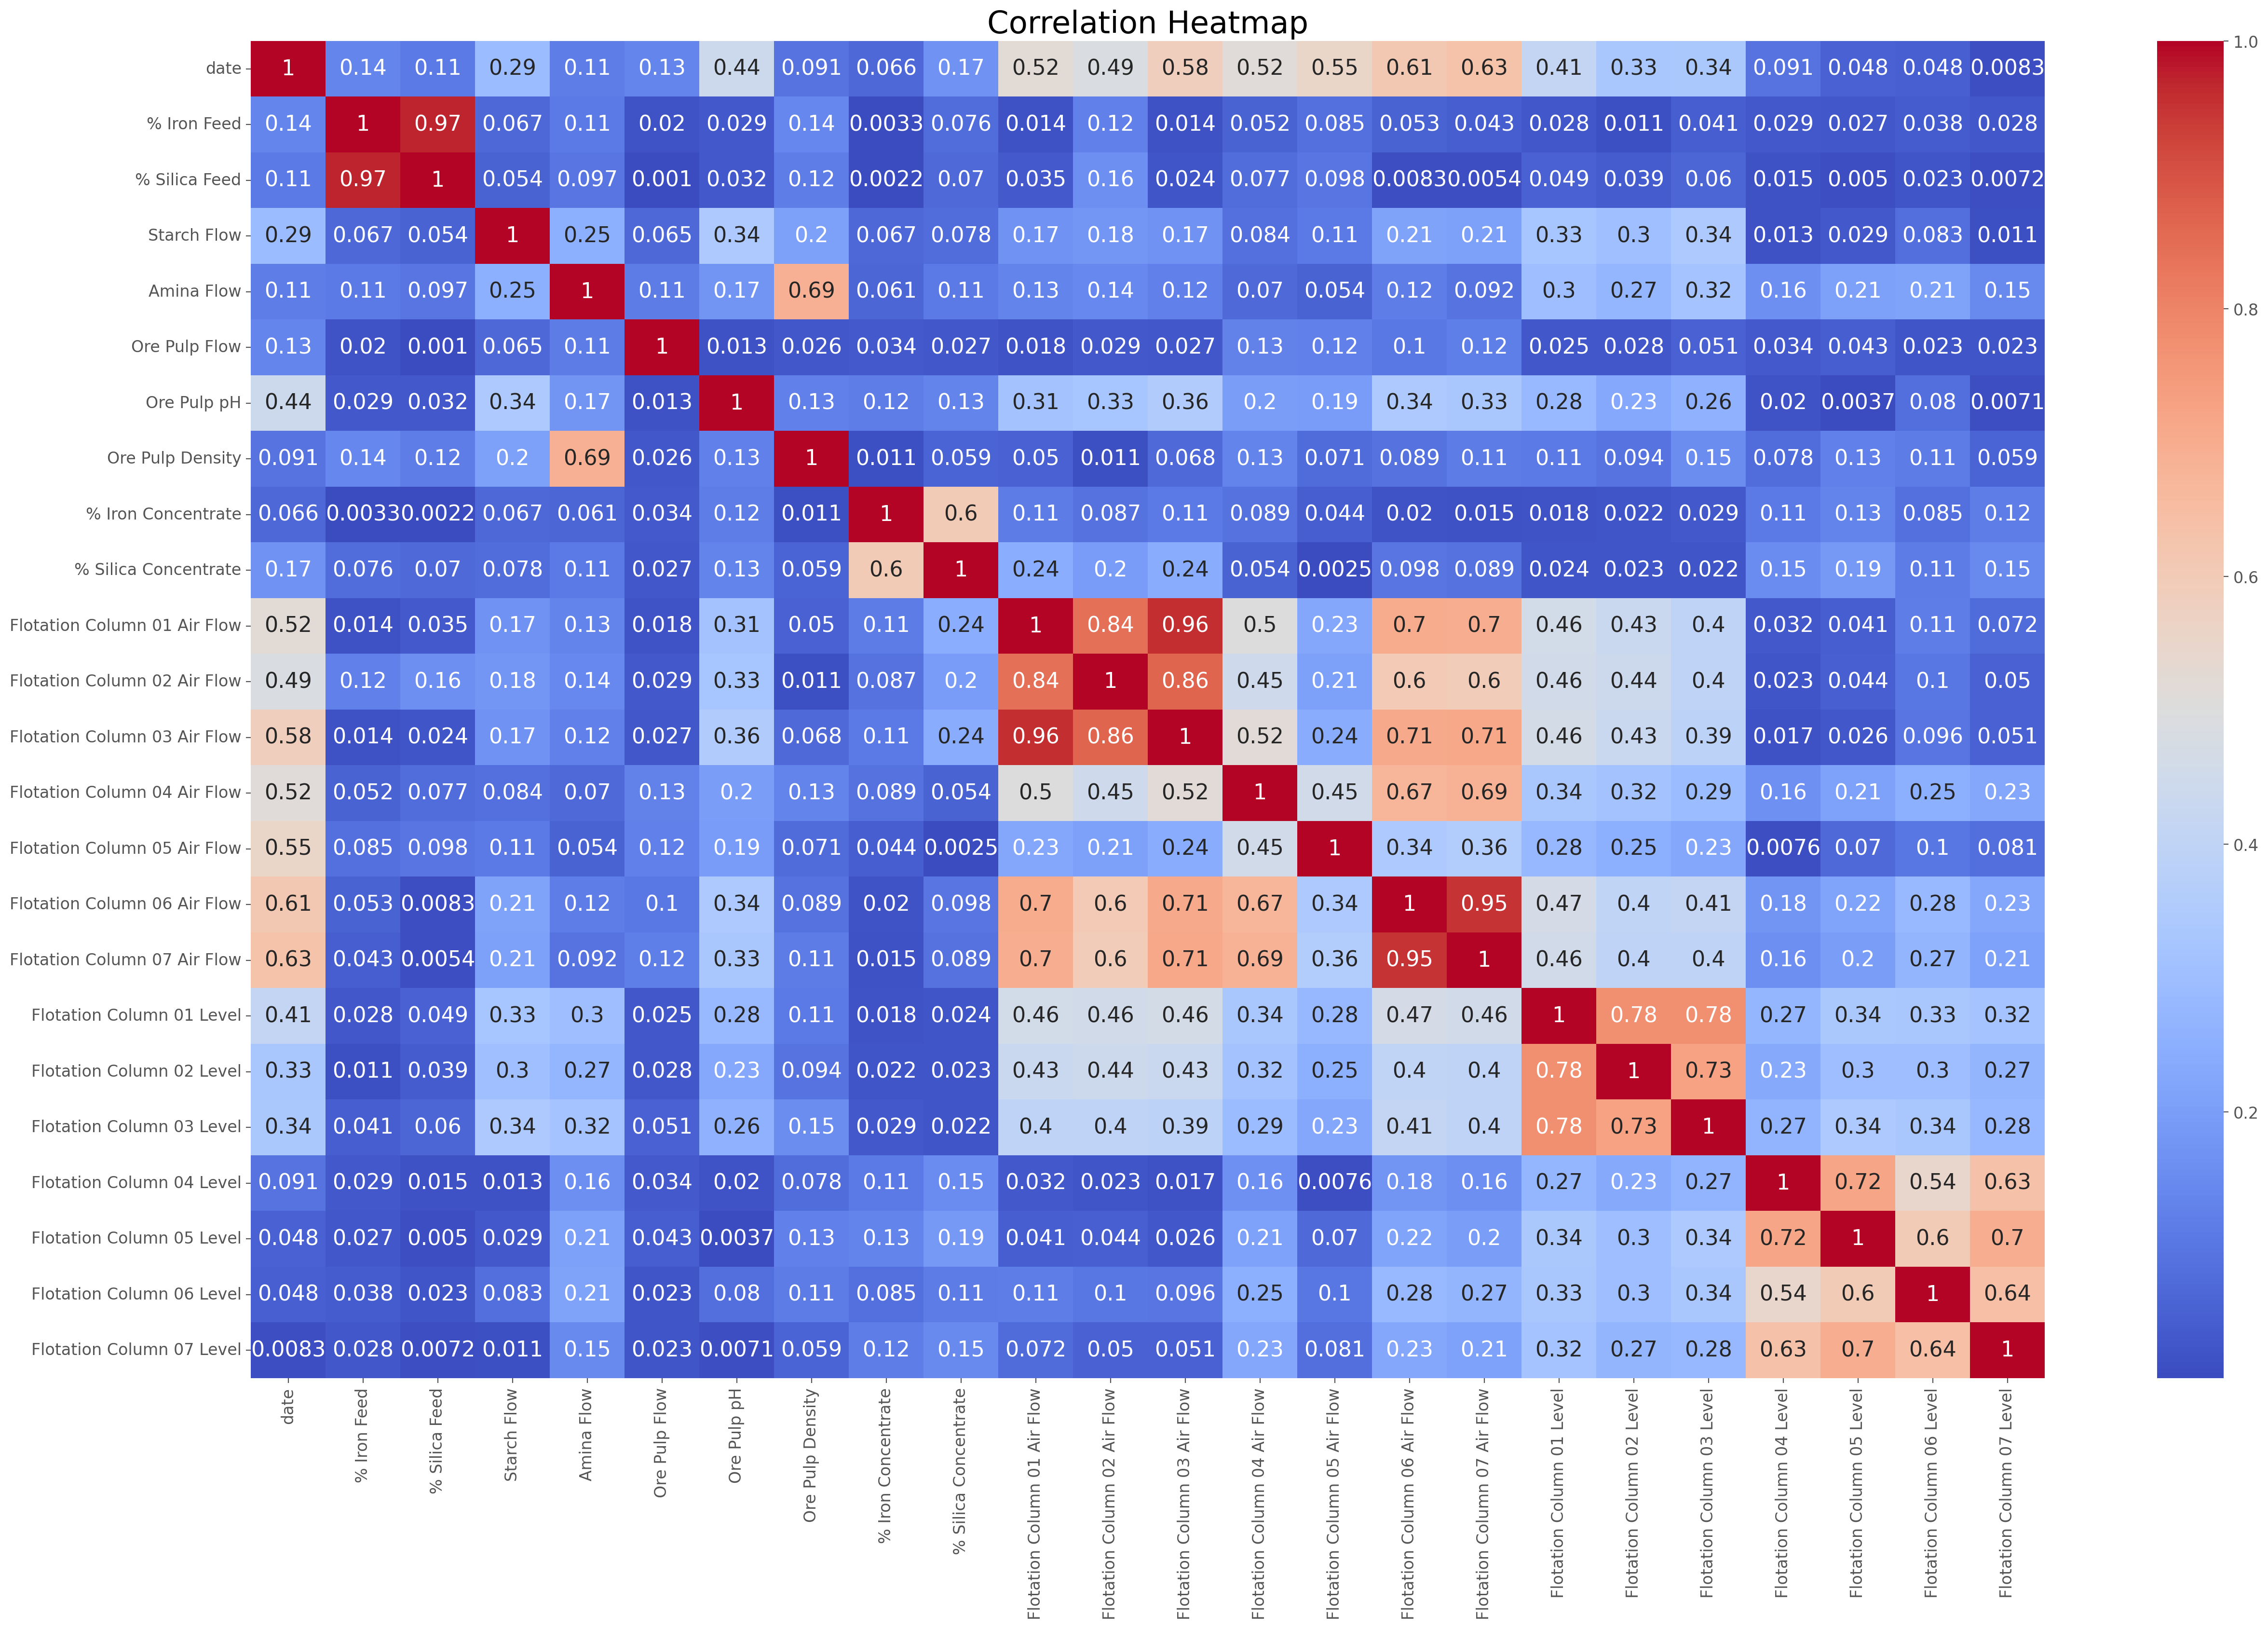

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = data.corr().abs()

# Plot heatmap
plt.figure(figsize=(30, 18))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [50]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif_from_df(df):
    # Keep only numeric features
    numeric_df = df.select_dtypes(include=[np.number]).copy()

    # Drop constant columns
    numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1]

    # Ensure no infs
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan).dropna()

    # Add constant
    X = add_constant(numeric_df)

    # Compute VIF
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data.sort_values(by="VIF", ascending=False)

# Example use:
vif_result = calculate_vif_from_df(filtered_data)
print(vif_result)


                        Variable            VIF
0                          const  115861.129347
16  Flotation Column 07 Air Flow     138.082173
15  Flotation Column 06 Air Flow     135.369523
1                    % Iron Feed      20.922994
2                  % Silica Feed      20.515373
12  Flotation Column 03 Air Flow      18.864253
10  Flotation Column 01 Air Flow      13.706406
23     Flotation Column 07 Level      11.091524
22     Flotation Column 06 Level       8.174605
21     Flotation Column 05 Level       6.577351
20     Flotation Column 04 Level       5.698261
17     Flotation Column 01 Level       4.616771
19     Flotation Column 03 Level       4.161201
11  Flotation Column 02 Air Flow       3.760713
18     Flotation Column 02 Level       3.444520
9           % Silica Concentrate       3.166855
8             % Iron Concentrate       3.050468
13  Flotation Column 04 Air Flow       2.640292
4                     Amina Flow       2.346382
7               Ore Pulp Density       2

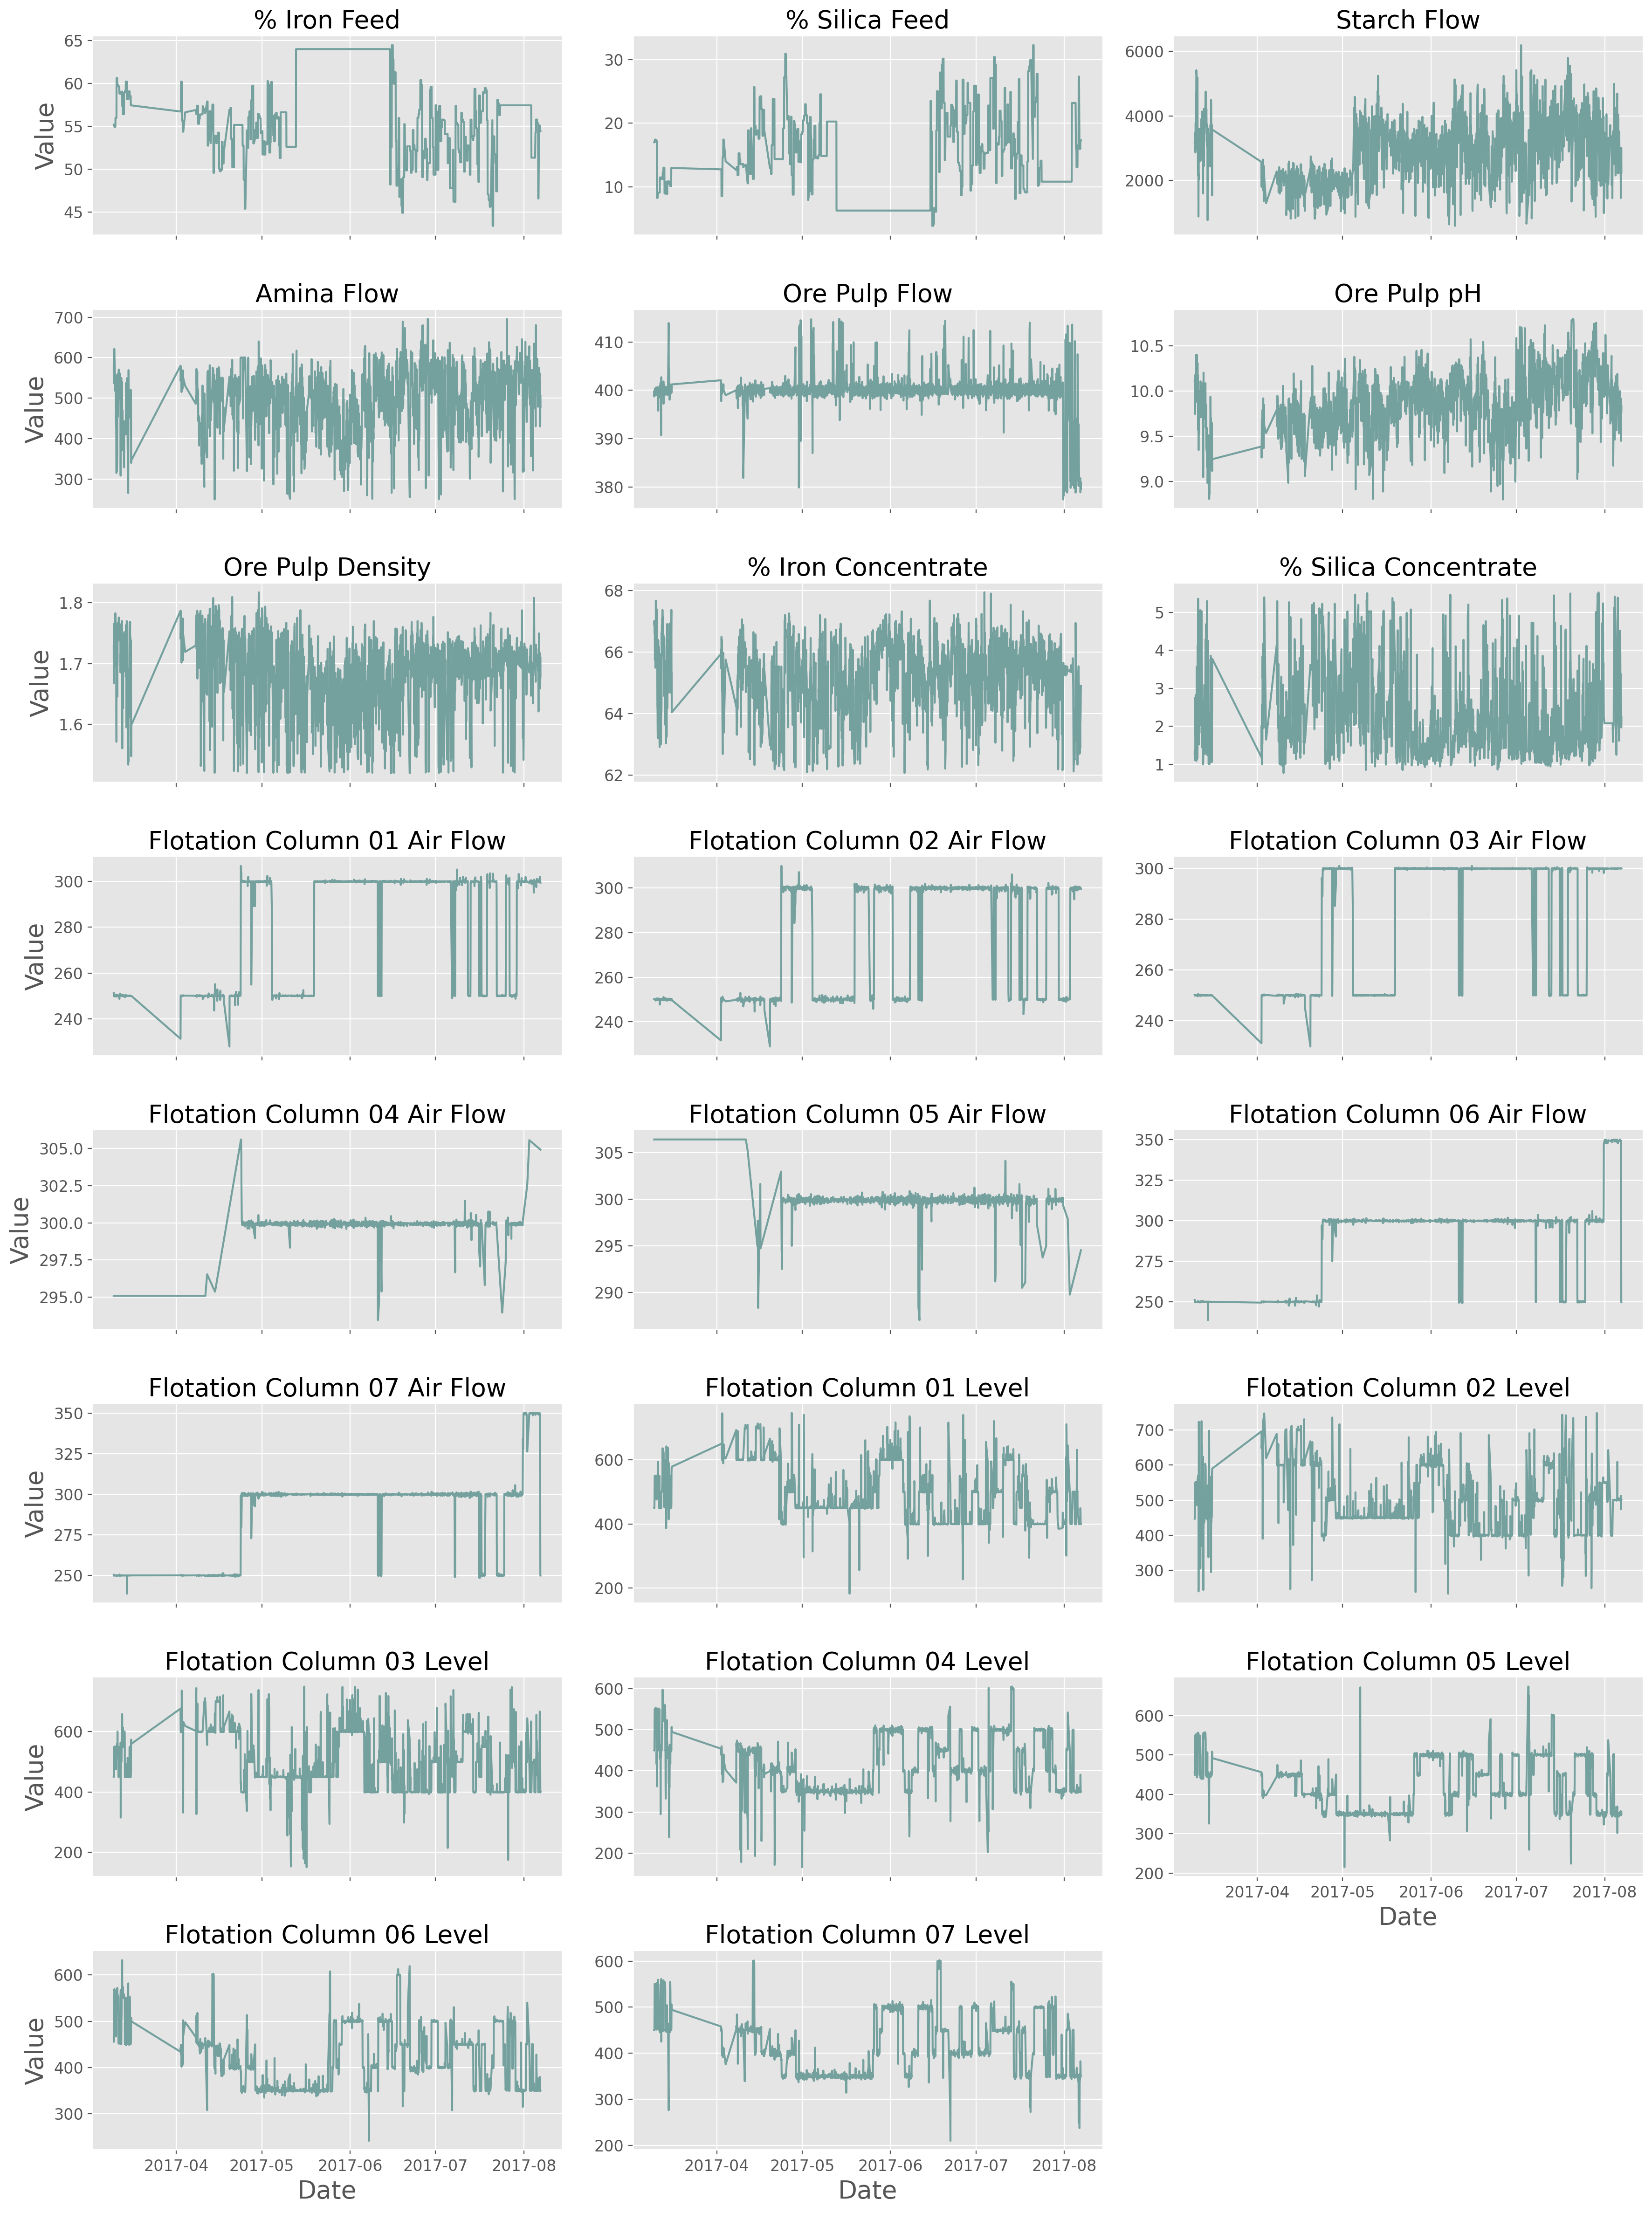

In [26]:
import seaborn as sns
import pandas as pd

# Melt into long format

# Assuming data_hourly is your DataFrame
numeric_cols = filtered_data.select_dtypes(include='number').columns.tolist()  # For Pandas 1.0.0 and above


long_df = filtered_data.melt(id_vars='date', value_vars=numeric_cols,
                           var_name='feature', value_name='value')

# Plot using seaborn
g = sns.FacetGrid(long_df, col='feature', col_wrap=3, height=3, aspect=2, sharex=True, sharey=False)
g.map_dataframe(sns.lineplot, x='date', y='value')
g.set_titles("{col_name}")
g.set_axis_labels("Date", "Value")
g.tight_layout()
plt.show()


In [33]:
filtered_data.shape

(2669, 24)

In [ ]:
#filtered_data.to_csv('train_data2.csv', index=False)